# NSRDB on AWS

In [1]:
%matplotlib inline
import h5pyd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import seaborn as sns
import time

# Plotting settings
mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)
mpl.rc('font', size=16)
sns.set_style("white")
sns.set_style("ticks")


def nearest_site(tree, coords):
    """
    Find nearest NSRDB site to coordinate (lat, lon) of interest
    
    Parameters
    ----------
    tree : cKDTree
        Pre-built KDTree on the NSRDB site coordintes
    coords : tuple
        (lat, lon) coordinates of interest
        
    Returns
    -------
    site_idx : int
        Site index in the NSRDB datasets
    """
    lat_lon = np.array(coords)
    _, site_idx = tree.query(lat_lon)
    return site_idx


def nearest_timestep(time_index, timestep):
    """
    Find the nearest NSRDB timestep to timestep of interest
    
    Parameters
    ----------
    time_index : pd.Datetime_Index
        NSRDB Datetime index
    timestep : datetime
        Datetime step of interest
        
    Returns
    -------
    time_idx : int
        Time index in the NSRDB datasets
    """
    delta = np.abs(time_index - timestep)
    time_idx = delta.argmin()
    
    return time_idx


def get_region_idx(meta, value, column='state'):
    """
    Find sites associated with given region
    
    Parameters
    ----------
    meta : pd.DataFrame
        NSRDB site meta data
    value : str
        Regional value filter to
    column : str
        Column in the meta data to filter on
        
    Returns
    -------
    region_idx : list
        Index of all sites corresponding to region of interest
    """
    col_data = meta[column].str.decode('utf-8')
    region_idx = meta.index[col_data == value].values
    
    return region_idx


def get_map_coords(meta, time_index, state, date):
    """
    Find spatial and temporal indices for given state and day
    
    Parameters
    ----------
    meta : pd.DataFrame
        NSRDB site meta data
    value : str
        Regional value filter to
    column : 
        
    Returns
    -------
    time_idx : slice
        Slice of time-index that corresponds to given date
    site_idx : list
        Indices for all sites in given state
    """
    time_idx = np.where(time_index.date == date)[0]
    time_idx = slice(time_idx[0], time_idx[-1] + 1)
    
    site_idx = get_region_idx(meta, state)
    
    return time_idx, site_idx

with h5pyd.File('/nrel/nsrdb/nsrdb_2017.h5', mode='r') as f:
    NSRDB_COORDS = f['coordinates'][...]
    META = pd.DataFrame(f['meta'][...])
    TIME_INDEX_2017 = pd.to_datetime(f['time_index'][...].astype(str))
    
TREE = cKDTree(NSRDB_COORDS)

# Time-series extraction

In [2]:
# Please pick a year of NSRDB data (1998-2017)
year = 2017

# Please provide coordinates of interest (latitude, longitude)
coords = (38.885083, -77.024739)  # NREL DC office

In [70]:
idx = get_region_idx(META, 'District of Columbia', column='state')
date = pd.to_datetime('2017-07-04').date()
time_idx = np.where(TIME_INDEX_2017.date == date)[0]
time_idx = slice(time_idx[0], time_idx[-1] + 1)

In [71]:
ts = time.time()

path = '/nrel/nsrdb/nsrdb_{}.h5'.format(year)
with h5pyd.File(path, mode='r') as f:
     ghi = f['ghi'][time_idx][:, idx]

print('{:.4f}'.format(time.time() - ts))

21.0073


In [75]:
ghi.shape

(48, 11)

In [78]:
country_data = META['country'].str.decode('utf-8')
us_idx = country_data == 'United States'
state_data = META.loc[us_idx, 'state'].str.decode('utf-8')
conus_idx = state_data.isin(['Alaska', 'Hawaii', 'AK', 'HI'])
conus_idx = state_data.index[~conus_idx]

NameError: name 'state_date' is not defined

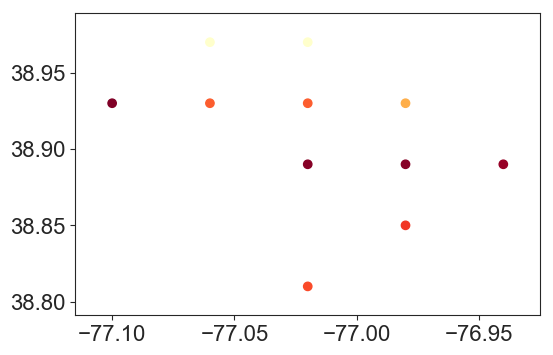

In [74]:
meta = META.iloc[idx]
lon = meta['longitude'].values
lat = meta['latitude'].values

fig = plt.figure(figsize=(6, 4), dpi=100)
axis = fig.add_subplot(111)
axis.scatter(lon, lat, c=ghi[-1], cmap='YlOrRd')
plt.show()